In [ ]:
# Cell 1 - Imports and global settings
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import joblib
RANDOM_STATE = 42

# plotting defaults
sns.set(style='whitegrid', context='notebook', font_scale=1.05)
plt.rcParams['figure.figsize'] = (10, 6)


In [ ]:
# Cell 2 - Helper utilities
def load_csv_safe(path):
    """Load CSV with basic error checks."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV file not found at: {path}")
    try:
        df = pd.read_csv(path)
    except Exception as e:
        raise IOError(f"Failed to read CSV: {e}")
    return df

def normalize_column_names(df):
    """Make column names consistent (lowercase, underscore)."""
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]
    return df

def report_df_basic(df):
    print("Shape:", df.shape)
    print("\nColumns:", list(df.columns))
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())
    display(df.head())
    display(df.describe(include='all').T)


In [4]:
# Cell 3 - Load dataset
DATA_PATH = '/content/StudentsPerformance_3_lyst1729690388778.csv'  # adjust if different
df = load_csv_safe(DATA_PATH)
df = normalize_column_names(df)
report_df_basic(df)

Shape: (1000, 8)

Columns: ['gender', 'race/ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course', 'math_score', 'reading_score', 'writing_score']

Data types:
gender                         object
race/ethnicity                 object
parental_level_of_education    object
lunch                          object
test_preparation_course        object
math_score                      int64
reading_score                   int64
writing_score                   int64
dtype: object

Missing values per column:
gender                         0
race/ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

Duplicate rows: 0


,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental_level_of_education,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_preparation_course,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math_score,1000.0,NaN,NaN,NaN,66.089,15.16308,0.0,57.0,66.0,77.0,100.0
reading_score,1000.0,NaN,NaN,NaN,69.169,14.600192,17.0,59.0,70.0,79.0,100.0
writing_score,1000.0,NaN,NaN,NaN,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Cell 4 - Quick rename mapping (if original names vary)
# Common expected names: gender, race/ethnicity, parental_level_of_education, lunch, test_preparation_course, math_score, reading_score, writing_score
# Make sure expected columns exist; try best-effort mapping if names different.
expected_cols = {
    'gender': ['gender'],
    'race_ethnicity': ['race/ethnicity', 'race_ethnicity', 'race'],
    'parental_level_of_education': ['parental_level_of_education', 'parental_level_of_education', 'parental_level_of_education'],
    'lunch': ['lunch'],
    'test_preparation_course': ['test_preparation_course', 'test_preparation'],
    'math_score': ['math_score', 'math score', 'mathscore'],
    'reading_score': ['reading_score', 'reading score', 'readingscore'],
    'writing_score': ['writing_score', 'writing score', 'writingscore']
}

col_map = {}
for canonical, variants in expected_cols.items():
    for v in variants:
        v_norm = v.strip().lower().replace(' ', '_').replace('-', '_')
        if v_norm in df.columns:
            col_map[v_norm] = canonical
            break

# apply mapping
df = df.rename(columns={col: col_map[col] for col in col_map})
print("After renaming, columns:", list(df.columns))
# ensure required columns exist
required = ['gender','race_ethnicity','parental_level_of_education','lunch','test_preparation_course',
            'math_score','reading_score','writing_score']
missing_required = [c for c in required if c not in df.columns]
if missing_required:
    raise ValueError(f"Missing expected columns: {missing_required}")


After renaming, columns: ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course', 'math_score', 'reading_score', 'writing_score']


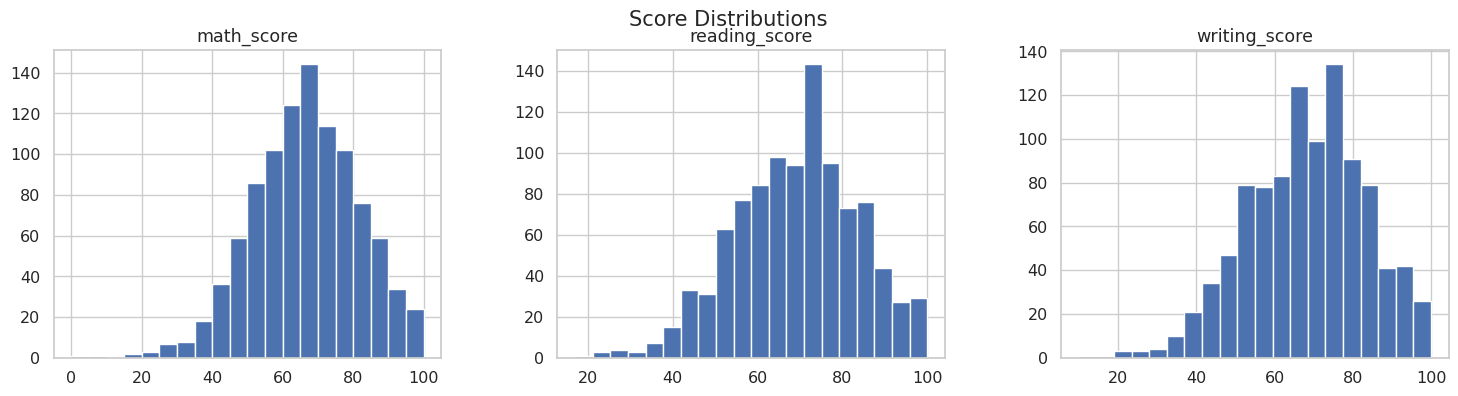

,count,mean,std,min,25%,50%,75%,max
math_score,1000.0,66.089,15.163080,0.0,57.00,66.0,77.0,100.0
reading_score,1000.0,69.169,14.600192,17.0,59.00,70.0,79.0,100.0
writing_score,1000.0,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


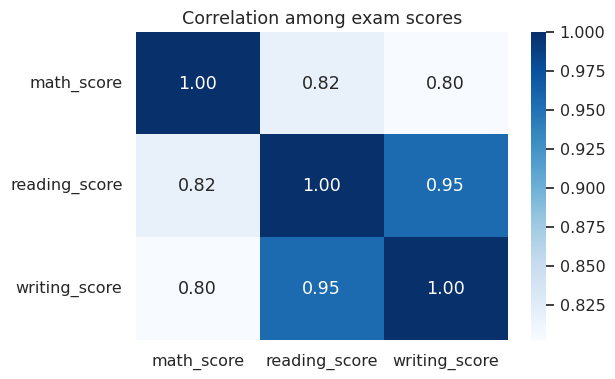

In [6]:
# Cell 5 - EDA: distributions & basic visuals
# Histograms for scores
score_cols = ['math_score','reading_score','writing_score']
df[score_cols].hist(bins=20, layout=(1,3), figsize=(18,4))
plt.suptitle("Score Distributions")
plt.show()

# descriptive stats for scores
display(df[score_cols].describe().T)

# correlation heatmap for numerical features (scores)
corr = df[score_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues')
plt.title("Correlation among exam scores")
plt.show()


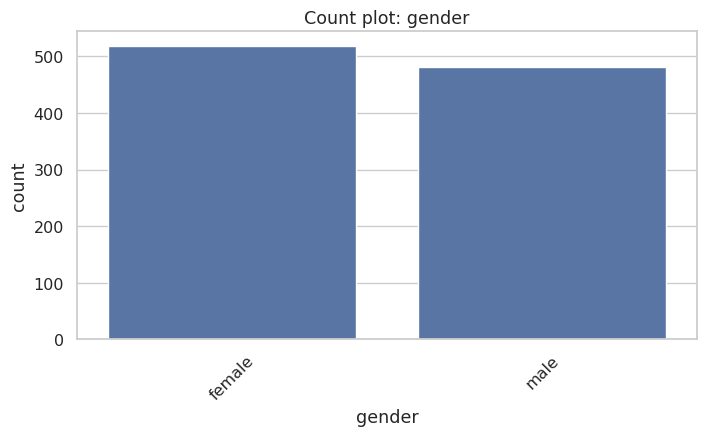

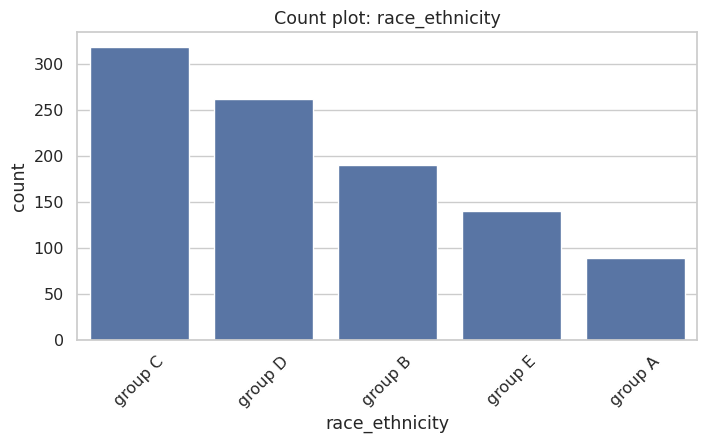

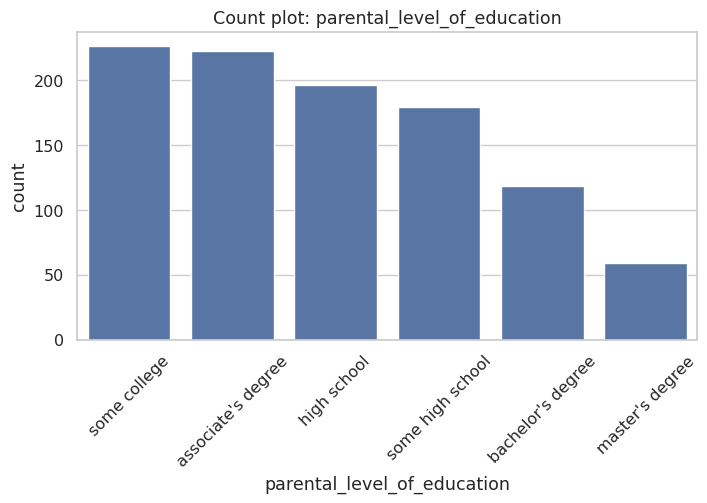

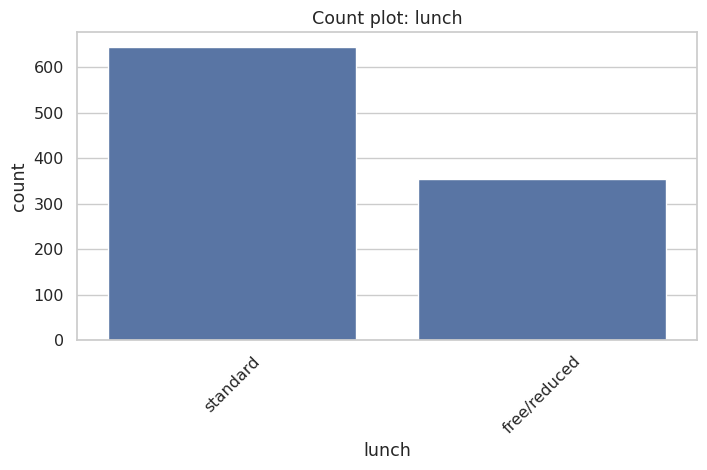

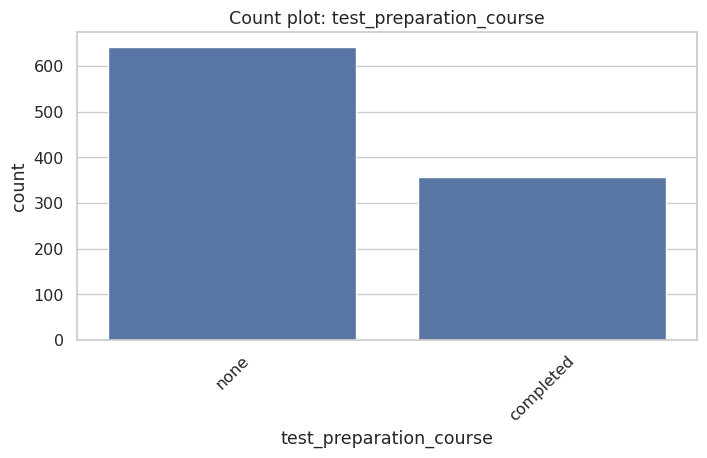

In [7]:
# Cell 6 - EDA: categorical counts
cat_cols = ['gender','race_ethnicity','parental_level_of_education','lunch','test_preparation_course']
for c in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=c, order=df[c].value_counts().index)
    plt.title(f"Count plot: {c}")
    plt.xticks(rotation=45)
    plt.show()


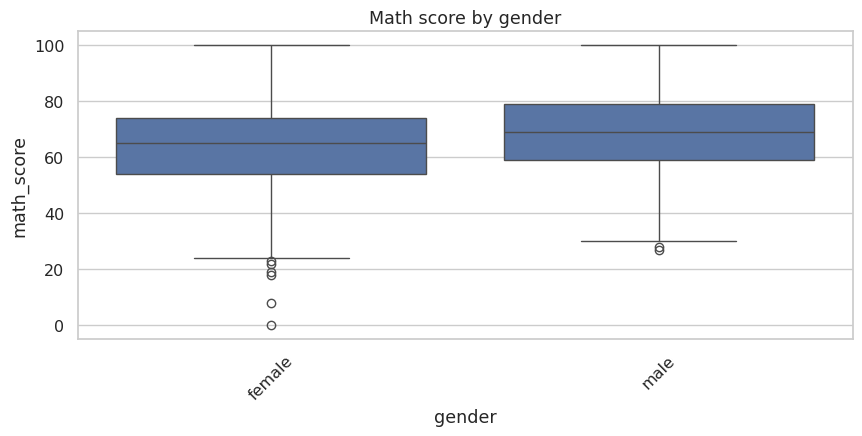

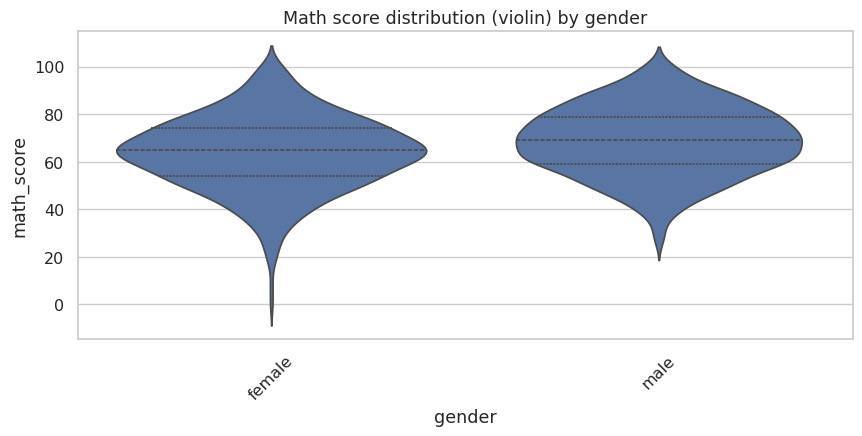

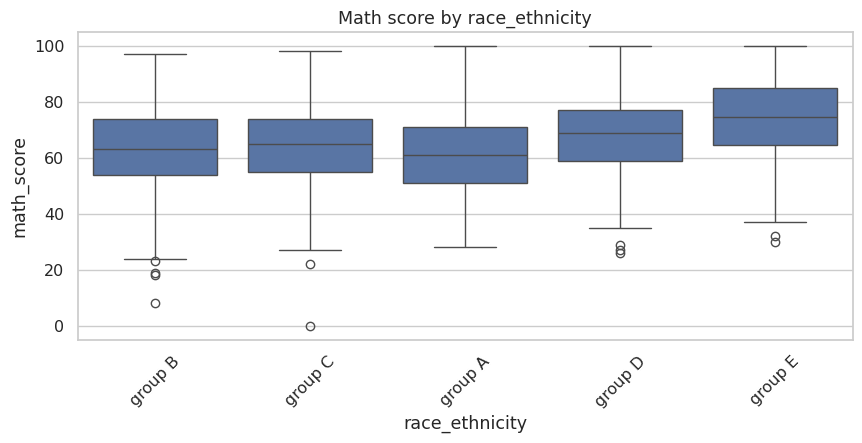

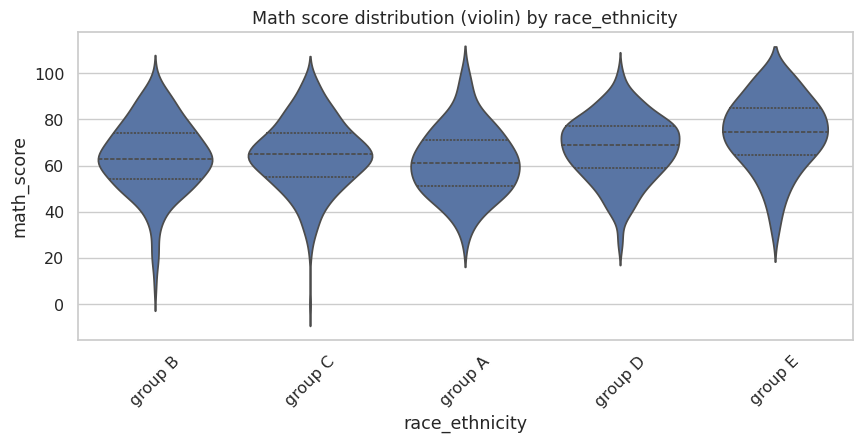

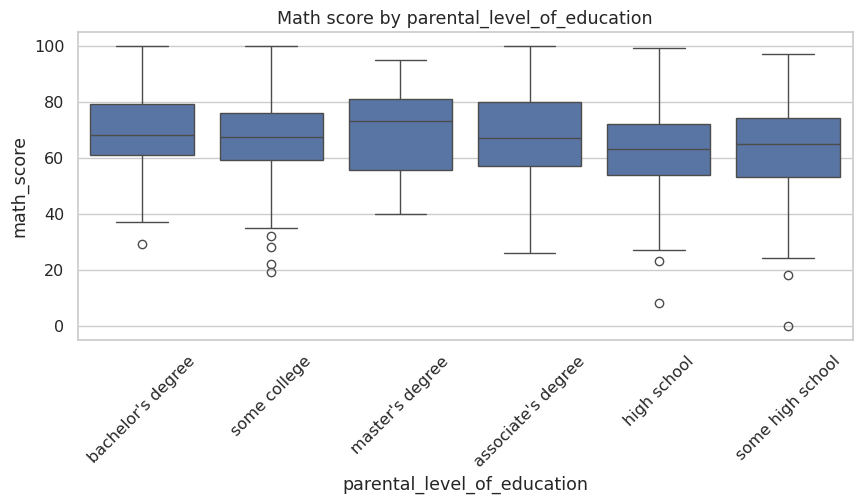

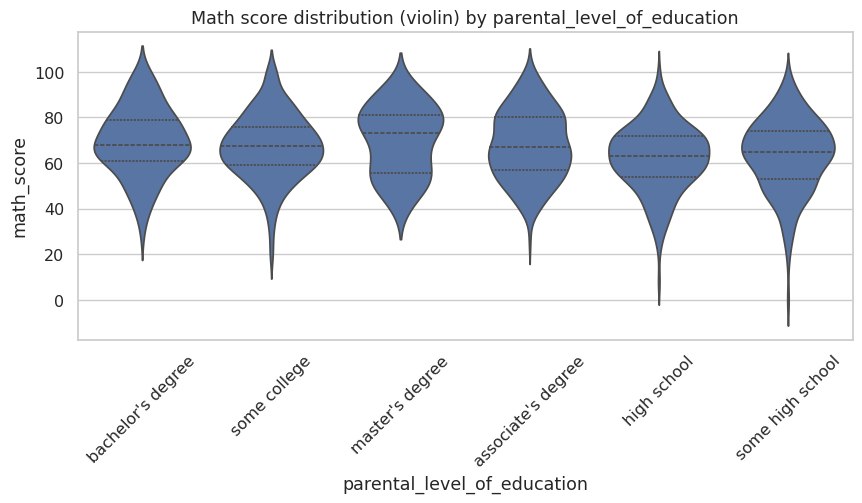

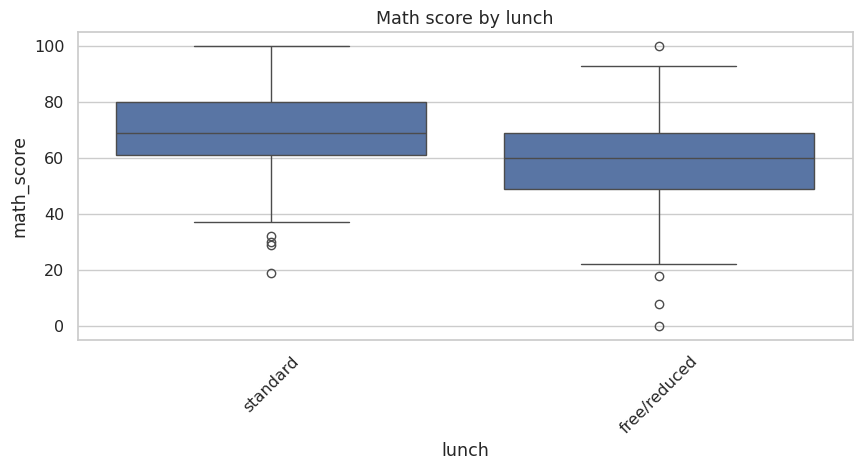

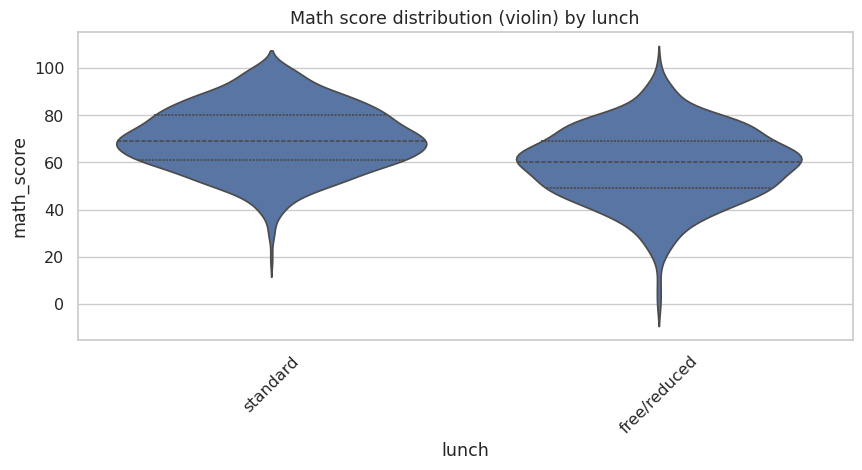

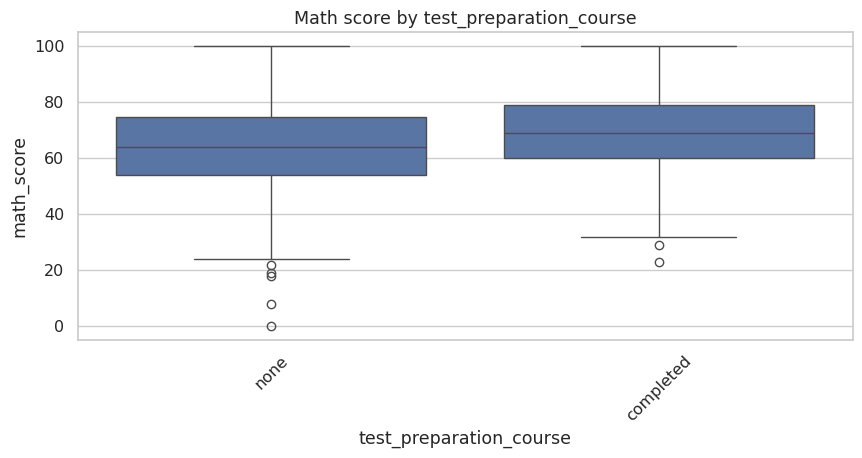

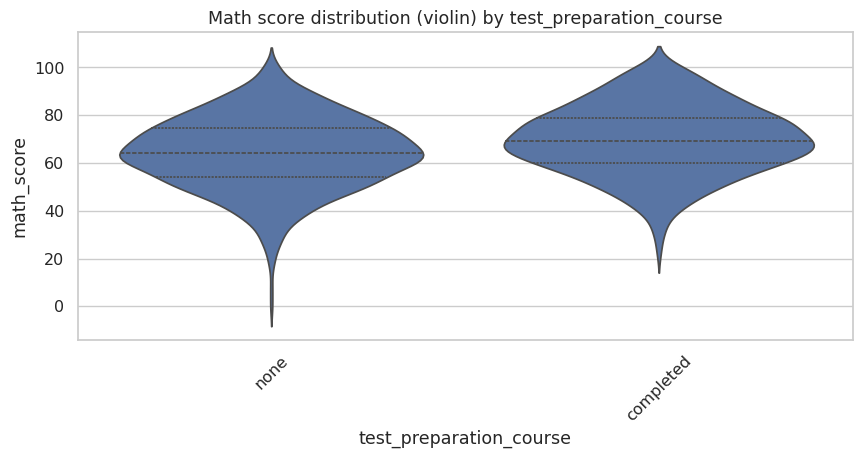

In [8]:
# Cell 7 - Score distributions by categorical variables (boxplots + violin)
for c in cat_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=c, y='math_score', data=df)
    plt.title(f"Math score by {c}")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10,4))
    sns.violinplot(x=c, y='math_score', data=df, inner='quartile')
    plt.title(f"Math score distribution (violin) by {c}")
    plt.xticks(rotation=45)
    plt.show()


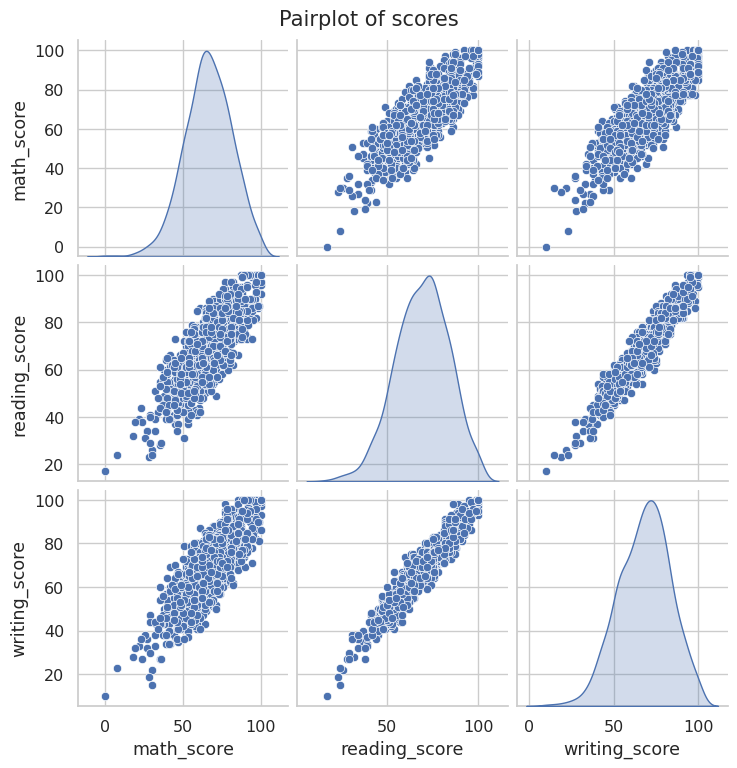

In [9]:
# Cell 8 - Pairplot (may be slow; sample if needed)
try:
    sns.pairplot(df[score_cols], diag_kind='kde')
    plt.suptitle("Pairplot of scores", y=1.02)
    plt.show()
except Exception as e:
    print("Pairplot failed or too slow; showing pairwise scatter matrix instead.", e)
    pd.plotting.scatter_matrix(df[score_cols], figsize=(10,10))
    plt.show()


In [10]:
# Cell 9 - Create derived features
df_model = df.copy()
df_model['total_score'] = df_model['math_score'] + df_model['reading_score'] + df_model['writing_score']
df_model['avg_score'] = df_model['total_score'] / 3.0
# show new columns
display(df_model[['math_score','reading_score','writing_score','total_score','avg_score']].head())


,math_score,reading_score,writing_score,total_score,avg_score
0,72,72,74,218,72.666667
1,69,90,88,247,82.333333
2,90,95,93,278,92.666667
3,47,57,44,148,49.333333
4,76,78,75,229,76.333333


In [11]:
# Cell 10 - Encoding categorical variables
# We'll label-encode binary-like columns and use one-hot for nominal ones.
# For simpler implementation, use pandas.get_dummies for multi-category variables.

# Label encode gender and test_preparation_course (they are often two-level)
df_enc = df_model.copy()
# safe mapping in case values aren't standard
df_enc['gender'] = df_enc['gender'].astype(str)
df_enc['test_preparation_course'] = df_enc['test_preparation_course'].astype(str)

# binary mapping where possible
if set(df_enc['gender'].unique()) <= {'male','female'}:
    df_enc['gender_male'] = (df_enc['gender']=='male').astype(int)
else:
    # fallback to get_dummies
    df_enc = pd.get_dummies(df_enc, columns=['gender'], drop_first=True)

if set(df_enc['test_preparation_course'].unique()) <= {'completed','none','none '}:
    df_enc['prep_completed'] = (df_enc['test_preparation_course'].str.lower().str.contains('complete')).astype(int)
else:
    df_enc = pd.get_dummies(df_enc, columns=['test_preparation_course'], drop_first=True)

# One-hot encode race_ethnicity, parental_level_of_education, lunch
to_ohe = []
if 'race_ethnicity' in df_enc.columns:
    to_ohe.append('race_ethnicity')
if 'parental_level_of_education' in df_enc.columns:
    to_ohe.append('parental_level_of_education')
if 'lunch' in df_enc.columns:
    to_ohe.append('lunch')

df_enc = pd.get_dummies(df_enc, columns=to_ohe, drop_first=True)

# drop original raw text columns that were encoded
for c in ['gender','test_preparation_course']:
    if c in df_enc.columns:
        df_enc = df_enc.drop(columns=[c])

print("Encoded dataframe shape:", df_enc.shape)
display(df_enc.head())


Encoded dataframe shape: (1000, 17)


,math_score,reading_score,writing_score,total_score,avg_score,gender_male,prep_completed,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,parental_level_of_education_bachelor's degree,parental_level_of_education_high school,parental_level_of_education_master's degree,parental_level_of_education_some college,parental_level_of_education_some high school,lunch_standard
0,72,72,74,218,72.666667,0,0,True,False,False,False,True,False,False,False,False,True
1,69,90,88,247,82.333333,0,1,False,True,False,False,False,False,False,True,False,True
2,90,95,93,278,92.666667,0,0,True,False,False,False,False,False,True,False,False,True
3,47,57,44,148,49.333333,1,0,False,False,False,False,False,False,False,False,False,False
4,76,78,75,229,76.333333,1,0,False,True,False,False,False,False,False,True,False,True


In [12]:
# Cell 11 - Prepare X and y, train-test split
TARGET = 'math_score'

# Select feature columns: exclude original score columns only if you want to predict math without using reading/writing.
# But the project suggests using other features including reading/writing are allowed. We'll keep reading and writing (strong predictors).
feature_cols = [c for c in df_enc.columns if c != TARGET]

X = df_enc[feature_cols].copy()
y = df_enc[TARGET].copy()

# Optional: keep a copy of X for feature name reference after scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (800, 16) Test shape: (200, 16)


In [13]:
# Cell 12 - Feature scaling (for SVR we need scaling)
scaler = StandardScaler()
# We'll create scaled versions for models that need scaling (SVR), but tree-based models don't require scaling.
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Fit scaler on training numeric features
scaler.fit(X_train[numeric_cols])
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [14]:
# Cell 13 - Modeling: helper to train and evaluate models
def evaluate_model(model, X_tr, y_tr, X_te, y_te, cv=5, use_scaled=False):
    """Train model, compute CV r2 (on training), and evaluate on test set. Return metrics dict."""
    # fit
    m = model
    m.fit(X_tr, y_tr)
    # cross-val on training
    try:
        cv_scores = cross_val_score(m, X_tr, y_tr, cv=cv, scoring='r2')
        cv_r2_mean = np.mean(cv_scores)
        cv_r2_std = np.std(cv_scores)
    except Exception:
        cv_r2_mean = np.nan
        cv_r2_std = np.nan
    # predictions & metrics
    y_pred = m.predict(X_te)
    mae = mean_absolute_error(y_te, y_pred)
    mse = mean_squared_error(y_te, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_te, y_pred)
    metrics = {
        'model': m,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'cv_r2_mean': cv_r2_mean,
        'cv_r2_std': cv_r2_std,
        'y_pred': y_pred
    }
    return metrics


In [15]:
# Cell 14 - Instantiate models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
    'SVR_rbf': SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

results = {}
for name, mdl in models.items():
    # use scaled data for SVR, original for others
    if name.startswith('SVR'):
        res = evaluate_model(mdl, X_train_scaled, y_train, X_test_scaled, y_test, cv=5)
    else:
        res = evaluate_model(mdl, X_train, y_train, X_test, y_test, cv=5)
    results[name] = res
    print(f"{name}: R2={res['r2']:.4f}, RMSE={res['rmse']:.4f}, MAE={res['mae']:.4f}")


LinearRegression: R2=1.0000, RMSE=0.0000, MAE=0.0000
DecisionTree: R2=0.9416, RMSE=3.7683, MAE=2.9700
RandomForest: R2=0.9632, RMSE=2.9927, MAE=2.1240
GradientBoosting: R2=0.9566, RMSE=3.2481, MAE=2.5094
SVR_rbf: R2=0.7859, RMSE=7.2185, MAE=4.0963


In [16]:
# Cell 15 - Summary table of metrics
rows = []
for name, r in results.items():
    rows.append({
        'Model': name,
        'MAE': r['mae'],
        'MSE': r['mse'],
        'RMSE': r['rmse'],
        'R2': r['r2'],
        'CV_R2_mean': r['cv_r2_mean']
    })
metrics_df = pd.DataFrame(rows).sort_values('R2', ascending=False).reset_index(drop=True)
display(metrics_df)


,Model,MAE,MSE,RMSE,R2,CV_R2_mean
0,LinearRegression,5.915057e-14,5.656480e-27,7.520958e-14,1.000000,1.000000
1,RandomForest,2.124000e+00,8.956246e+00,2.992699e+00,0.963194,0.956752
2,GradientBoosting,2.509358e+00,1.055024e+01,3.248113e+00,0.956644,0.953461
3,DecisionTree,2.970000e+00,1.420000e+01,3.768289e+00,0.941645,0.917893
4,SVR_rbf,4.096316e+00,5.210645e+01,7.218480e+00,0.785868,0.840023


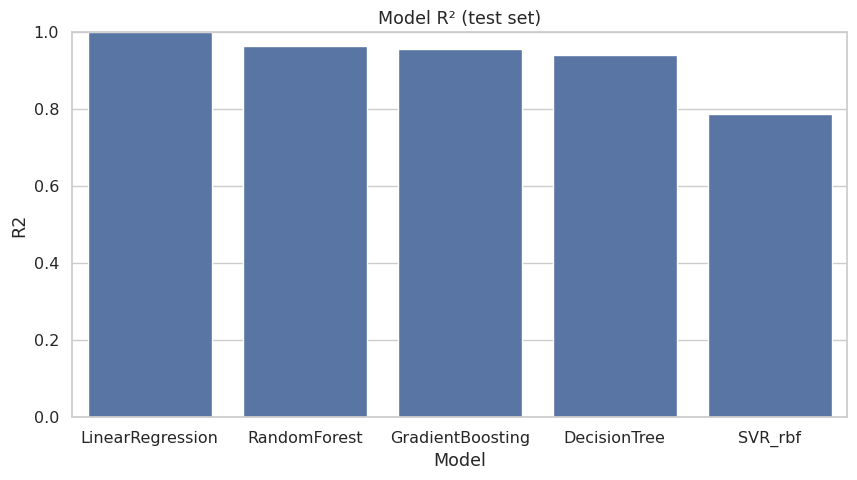

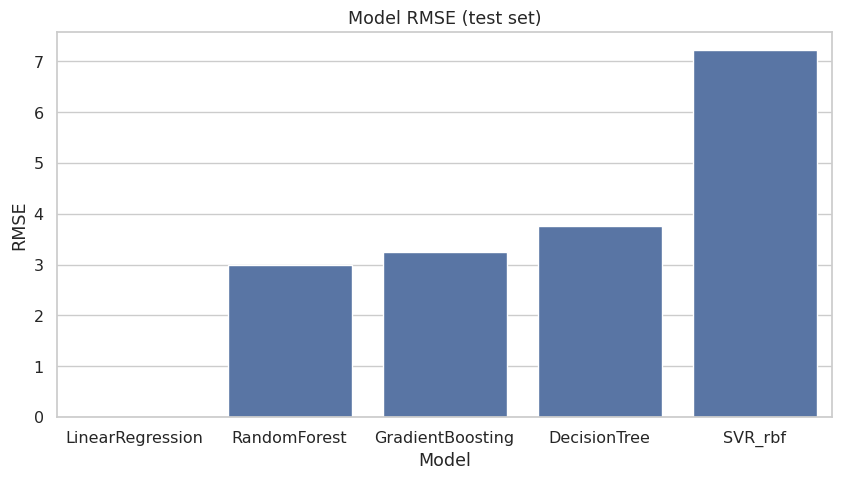

In [17]:
# Cell 16 - Visual: Model comparison (R2 & RMSE)
plt.figure(figsize=(10,5))
sns.barplot(data=metrics_df.sort_values('R2',ascending=False), x='Model', y='R2')
plt.title("Model R² (test set)")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=metrics_df.sort_values('RMSE'), x='Model', y='RMSE')
plt.title("Model RMSE (test set)")
plt.show()


In [18]:
# Cell 17 - Choose best model and perform hyperparameter tuning (RandomizedSearchCV on RandomForest as example)
# Identify best model by R2
best_model_name = metrics_df.iloc[0]['Model']
print("Best model by initial evaluation:", best_model_name)

# If RandomForest not top, still use RandomForest tuning because it typically performs well; else tune the top model.
tune_model_name = 'RandomForest'
if best_model_name != 'RandomForest':
    # decide if we should tune the best model (choice: tune RandomForest or the top model); we'll tune RandomForest
    tune_model_name = 'RandomForest'

print("Tuning model:", tune_model_name)

# Randomized search space
rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
rnd_search = RandomizedSearchCV(rf, param_dist, n_iter=30, cv=5, scoring='r2', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
rnd_search.fit(X_train, y_train)
print("Best params:", rnd_search.best_params_)
best_rf = rnd_search.best_estimator_


Best model by initial evaluation: LinearRegression
Tuning model: RandomForest
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


In [19]:
# Cell 18 - Evaluate tuned model on test set
best_rf_res = evaluate_model(best_rf, X_train, y_train, X_test, y_test, cv=5)
print("Tuned RandomForest performance:")
print(f"R2: {best_rf_res['r2']:.4f}, RMSE: {best_rf_res['rmse']:.4f}, MAE: {best_rf_res['mae']:.4f}")


Tuned RandomForest performance:
R2: 0.9651, RMSE: 2.9151, MAE: 2.0810


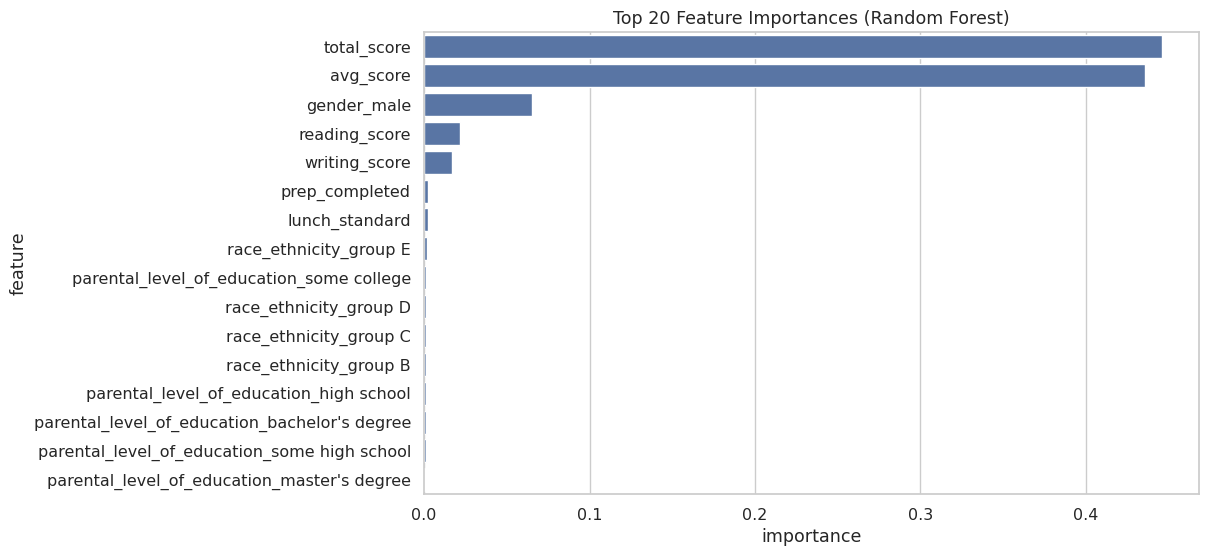

In [20]:
# Cell 19 - Feature importance visualization (from best_rf)
try:
    importances = best_rf.feature_importances_
    feat_names = X_train.columns
    feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature')
    plt.title("Top 20 Feature Importances (Random Forest)")
    plt.show()
except Exception as e:
    print("Feature importance plotting failed:", e)


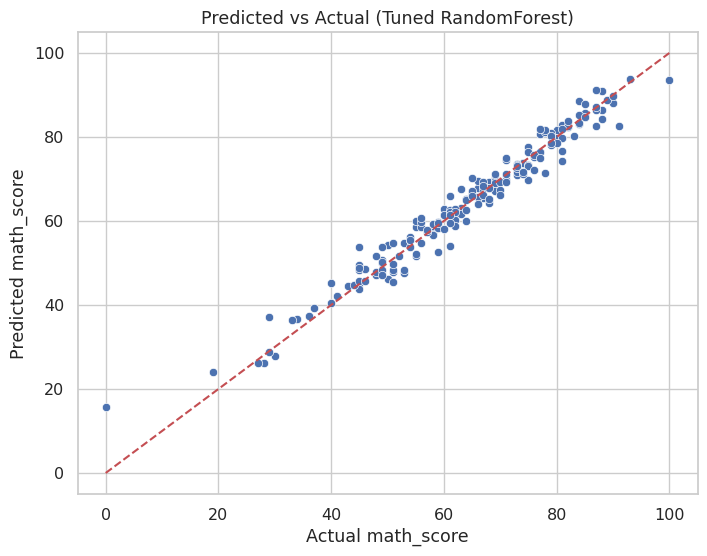

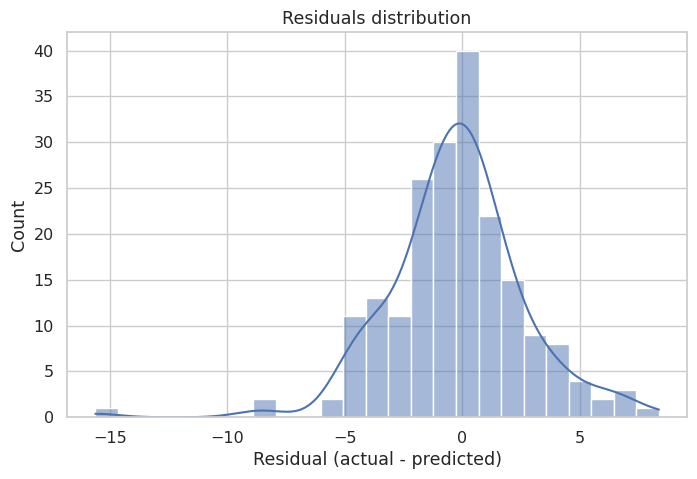

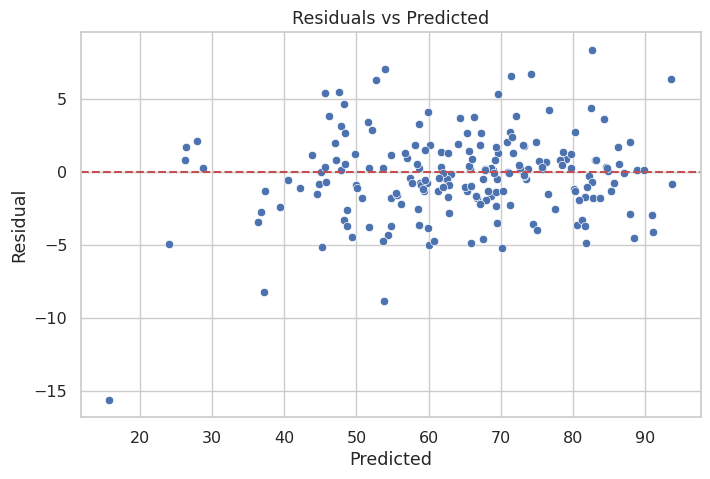

In [21]:
# Cell 20 - Prediction vs Actual and residuals plot (best model)
y_pred = best_rf.predict(X_test)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual math_score")
plt.ylabel("Predicted math_score")
plt.title("Predicted vs Actual (Tuned RandomForest)")
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=25, kde=True)
plt.title("Residuals distribution")
plt.xlabel("Residual (actual - predicted)")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()
